In [2]:
#import library yang dibutuhkan

import pandas as pd #library tabulasi data
import re #library untuk manipulasi teks
import numpy as np #library operasi perhitungan matematika
import matplotlib.pyplot as plt #library visualisasi data 2D
import seaborn as sns #library visualisasi data 3D
import math #library rumus matematika
import collections #library kontainer datatypes
from wordcloud import WordCloud #untuk visualisasi data string

### Load Data yang digunakan

In [3]:
data_kamusalay = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
data_kamusalay = data_kamusalay.rename (columns = {0: 'before', 1: 'after'})
data_twitter = pd.read_csv('data.csv', encoding='latin-1')
kamus_alay = dict(zip(data_kamusalay['before'], data_kamusalay['after']))
data_abusive = pd.read_csv('abusive.csv', header=None)

### Melihat 5 data teratas

In [4]:
data_twitter.head() #melihat 5 data teratas

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


### Melihat info dataframe data_twitter

In [5]:
data_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


### Cek duplikasi data pada dataframe

In [6]:
data_twitter.duplicated().sum()

125

### Drop/hapus data duplikat

In [7]:
data_twitter = data_twitter.drop_duplicates()

In [8]:
data_twitter.duplicated().sum() #cek ulang data duplikat setelah di-drop

0

### Jumlah data setelah drop duplicates

In [9]:
data_twitter.shape

(13044, 13)

### cek data null

In [10]:
data_twitter.isna().sum()

Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
dtype: int64

### Fungsi untuk membersihkan tweet

In [11]:
#fungsi cleansing 1, mengubah seluruh teks_twit menjadi karakter lowercase (huruf kecil)
def lowercase(teks_twit):
    return teks_twit.lower()

    #fungsi cleansing 2, menghapus/mengganti karakter yang tidak perlu
def remove_unnecessary_char(teks_twit):
        
        #step 1, hilangkan teks yang berawalan dari http sampai habis kalimat atau sampai first space
    teks_twit = re.sub(r'(http[^\s]+)', r'', teks_twit) 
        #step 2, remove \xDD substring 
    teks_twit = re.sub (r'(?:\\x[A-Fa-f0-9]{2})+', r'', teks_twit)
        #step 3, remove spesifik kata user
    teks_twit = re.sub(r'\buser\b', r'', teks_twit)
        #step 4, remove spesifik kata rt
    teks_twit = re.sub(r'\brt\b', r'', teks_twit)
        #step 5, remove \n
    teks_twit = re.sub(r"\\n",' ', teks_twit)
        #step 6, remove non alfanumerik karakter
    teks_twit = re.sub(r"[^A-Za-z0-9\s]+", ' ', teks_twit)
        #step 7, remove spesifik kata url
    teks_twit = re.sub(r'\burl\b', r'', teks_twit)
        #step 8, me-replace 2 atau lebih whitespace menjadi single space
    teks_twit = re.sub(r'\s{2,}', ' ', teks_twit) 
        #step 9, menghilangkan whitespace di awal dan di akhir teks_twit
    teks_twit = teks_twit.strip()

    return teks_twit
    
    #fungsi cleansing 3, mengubah kata alay menjadi kata yang lebih baku menurut file new_kamusalay.csv
def normalize_alay_word(teks_twit):
    return ' '.join([kamus_alay[kata] if kata in kamus_alay 
                                                else kata for kata in teks_twit.split(' ')])
    
    #fungsi cleansing 4, mengganti kata abusive yang ada di teks_twit dengan XXXXX. kata yang dianggap abusive adalah kata-kata yang ada di file abusive.csv
# def replace_abusive_word(teks_twit):
#     kamus_abusive = '|'.join(list(data_abusive[0]))
#     teks_twit = re.sub(kamus_abusive, r'XXXXX', teks_twit)

#     return teks_twit

    #menggabungkan seluruh fungsi cleansing menjadi 1 fungsi bernama preprocess
def preprocess(teks_twit):
    teks_twit = lowercase(teks_twit)
    teks_twit = remove_unnecessary_char(teks_twit)
    teks_twit = normalize_alay_word(teks_twit)
#     teks_twit = replace_abusive_word(teks_twit)
    return teks_twit
    
    #menyimpan hasil dari teks_twit ke dalam list kosong bernama tweets_cleansed
tweets_cleansed = [] 
for teks_twit in data_twitter['Tweet']:   #perulangan untuk setiap teks_twit di kolom Tweet
    teks_twit = preprocess(teks_twit)
    tweets_cleansed.append(teks_twit)

### Menambahkan kolom yang berisi hasil cleansing text Tweet

In [12]:
data_twitter['Tweet_cleaned'] = tweets_cleansed

data_twitter.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_cleaned
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,di saat semua cowok berusaha melacak perhatian...
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,siapa yang telat memberi tau kamu edan sarap g...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,41 kadang aku berpikir kenapa aku tetap percay...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,aku itu aku ku tau matamu sipit tapi dilihat d...
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,kaum cebong kafir sudah kelihatan dongoknya da...


#### Menghitung banyak kata pada tweet original (sebelum di bersihkan)

In [13]:
data_twitter['total_word_before'] = data_twitter.Tweet.apply(lambda sent: len(sent.split()))

#### Menghitung banyak kata pada tweet yang sudah dibersihkan

In [14]:
data_twitter['total_word_after'] = data_twitter.Tweet_cleaned.apply(lambda sent: len(sent.split()))

In [15]:
data_twitter.head(3)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_cleaned,total_word_before,total_word_after
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,di saat semua cowok berusaha melacak perhatian...,25,22
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,siapa yang telat memberi tau kamu edan sarap g...,21,19
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,41 kadang aku berpikir kenapa aku tetap percay...,37,39


In [42]:
data_twitter[['total_word_before','total_word_after']].describe()

,total_word_before,total_word_after
count,13044.000000,13044.000000
mean,17.264259,17.244787
std,10.242584,11.174161
min,1.000000,0.000000
25%,9.000000,8.000000
50%,15.000000,15.000000
75%,23.000000,24.000000
max,52.000000,65.000000


#### Tweet bersih dengan total kata terbanyak

In [43]:
data_twitter.loc[data_twitter['total_word_after'] == data_twitter['total_word_after'].max()]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_cleaned,total_word_before,total_word_after
8767,Salah. Yusril itu lupa. Waktu itu UU Pilkada D...,0,0,0,0,0,0,0,0,0,0,0,0,salah yusril itu lupa waktu itu undang undang ...,46,65


### Tweet yang mengandung hatespeech atau abusive word dengan jumlah kata terbanyak

In [52]:
#longest_hs_abusive_tweet = data_twitter[((data_twitter['Abusive']==1) | (data_twitter['HS']== 1)) & (data_twitter['total_word_after'].max())]

longest_hs_abusive_tweet = data_twitter[((data_twitter['Abusive']==1) | (data_twitter['HS']== 1))]
longest_hs_abusive_tweet = longest_hs_abusive_tweet[longest_hs_abusive_tweet['total_word_after'] == longest_hs_abusive_tweet['total_word_after'].max()][['Tweet_cleaned', 'total_word_after','HS', 'Abusive', 'Abusive Words']]

longest_hs_abusive_tweet


,Tweet_cleaned,total_word_after,HS,Abusive,Abusive Words
2603,apa komisi aparatur sipil negara berani lawan ...,54,1,0,[asing]
3053,jangan di biasakan menganggap cewek itu kayak ...,54,0,1,"[ngewe, pecun, ngewe, ngewe, anjir, sampah]"
10185,mending makan di sini lebih murah buang buang ...,54,0,1,[tai]


### Mencari 10 kata kasar yang paling banyak digunakan (top 10 abusive words)

In [16]:
#membuka file abusive.csv pada mode read 
#membuat variabel abusive_words yang menyimpan kata abusive dari abusive.csv

with open('abusive.csv', 'r') as abusive:
    abusive_words = [line.strip() for line in abusive]

In [17]:
#membuat fungsi find_abusive_words dengan 2 parameter. 
#untuk mencari daftar kata abusive yang digunakan pada setiap tweet
#hasil dari fungsi tsb adalah list yang menyimpan kata abusive dari setiap tweet

def find_abusive_words(tweet, abusive_words):
    return [word for word in tweet.lower().split() if word in abusive_words]

In [18]:
#menambahkan kolom/feature Abusive Word ke dataframe

data_twitter['Abusive Words'] = data_twitter['Tweet_cleaned'].apply(lambda x: find_abusive_words(x, abusive_words))

In [47]:
#menampilkan data frame dengan 4 features
selected_columns = ['Tweet_cleaned', 'HS', 'Abusive', 'Abusive Words']
data_twitter_selected = data_twitter.loc[:, selected_columns]

data_twitter_selected.head(5)

,Tweet_cleaned,HS,Abusive,Abusive Words
0,di saat semua cowok berusaha melacak perhatian...,1,1,[bego]
1,siapa yang telat memberi tau kamu edan sarap g...,0,1,"[edan, sarap]"
2,41 kadang aku berpikir kenapa aku tetap percay...,0,0,[]
3,aku itu aku ku tau matamu sipit tapi dilihat d...,0,0,[sipit]
4,kaum cebong kafir sudah kelihatan dongoknya da...,1,1,"[cebong, kafir, dungu]"


In [23]:
abusive_words_per_row = [word for words in data_twitter['Abusive Words'] for word in words]

word_count = collections.Counter(abusive_words_per_row)
sort_abusive_by_frequencies = word_count.most_common()
sort_abusive_by_frequencies

[('asing', 738),
 ('komunis', 726),
 ('cebong', 549),
 ('kafir', 370),
 ('rezim', 365),
 ('anjing', 291),
 ('tai', 271),
 ('antek', 270),
 ('onta', 231),
 ('goblok', 227),
 ('kampret', 213),
 ('babi', 200),
 ('kontol', 193),
 ('bodoh', 191),
 ('dungu', 188),
 ('sipit', 185),
 ('monyet', 172),
 ('bani', 171),
 ('ngentot', 156),
 ('anjir', 156),
 ('cacat', 156),
 ('bangsat', 155),
 ('tolol', 152),
 ('bajingan', 148),
 ('memek', 147),
 ('banci', 140),
 ('buta', 131),
 ('bacot', 127),
 ('bego', 123),
 ('munafik', 121),
 ('gila', 117),
 ('setan', 112),
 ('bangkai', 112),
 ('berengsek', 110),
 ('kunyuk', 106),
 ('idiot', 105),
 ('sampah', 98),
 ('ngewe', 95),
 ('budek', 79),
 ('bisu', 72),
 ('lgbt', 70),
 ('mampus', 68),
 ('sarap', 67),
 ('iblis', 66),
 ('titit', 66),
 ('buaya', 66),
 ('bejat', 64),
 ('cocot', 64),
 ('rejim', 64),
 ('edan', 62),
 ('hina', 62),
 ('najis', 62),
 ('congor', 62),
 ('kampungan', 61),
 ('dongok', 60),
 ('jijik', 60),
 ('bencong', 58),
 ('jamban', 57),
 ('picek', 5

In [24]:
top_10_words = word_count.most_common(10)

In [25]:
top_10_words

[('asing', 738),
 ('komunis', 726),
 ('cebong', 549),
 ('kafir', 370),
 ('rezim', 365),
 ('anjing', 291),
 ('tai', 271),
 ('antek', 270),
 ('onta', 231),
 ('goblok', 227)]

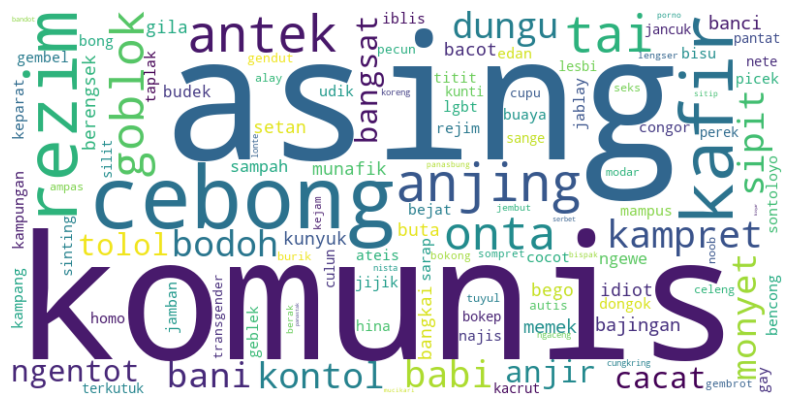

In [31]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sort_abusive_by_frequencies))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

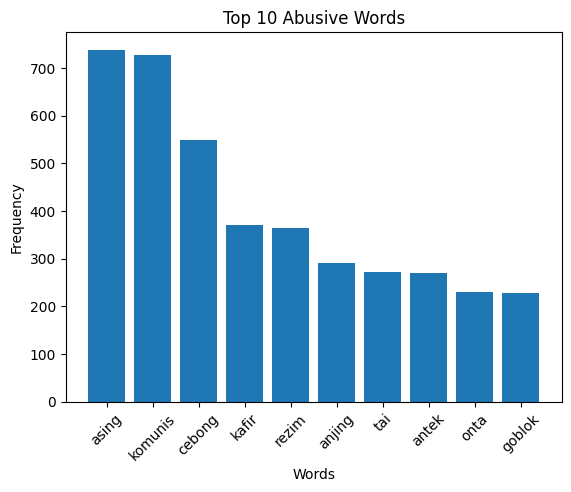

In [32]:
#mengubah variabel top_10_words menjadi dictionary
top_10_words = dict(word_count.most_common(10))

#mendefinisikan sumbu x dan y pada chart
x = list(top_10_words.keys())
y = list(top_10_words.values())

#membuat bar chart
plt.bar(x, y)


#mendefinisikan judul dan label pada chart
plt.title("Top 10 Abusive Words")
plt.xlabel("Words")
plt.xticks(rotation = 45)
plt.ylabel("Frequency")

plt.show()


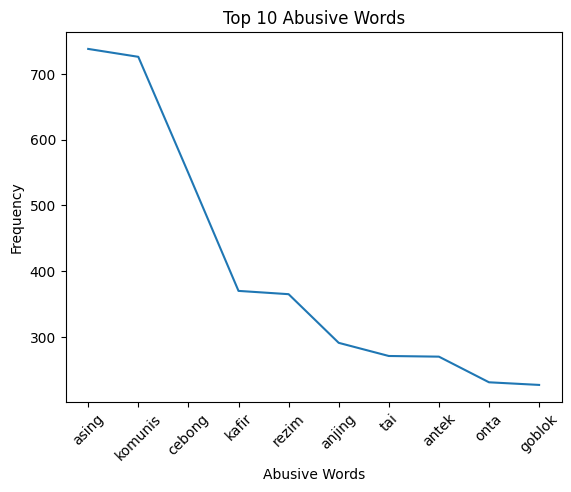

In [33]:
top_10_words = dict(word_count.most_common(10))

x = list(top_10_words.keys())
y = list(top_10_words.values())

plt.plot(x, y)

plt.title('Top 10 Abusive Words')
plt.xlabel('Abusive Words')
plt.ylabel('Frequency')

plt.xticks(rotation=45)

plt.show()


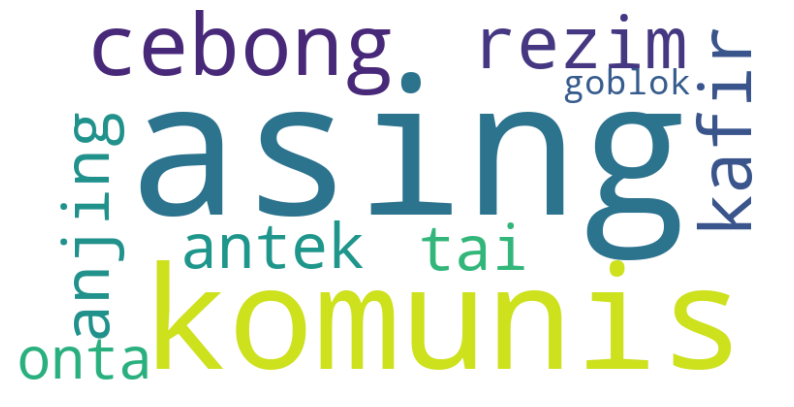

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_10_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [34]:
def tweet(col):
    if (col['HS'] == 0 and col['Abusive'] == 0):
        return 'Non hate speech atau kata kasar'
    else:
        return 'Mengandung hate speech atau kata kasar'

data_twitter['Category'] = data_twitter.apply(tweet, axis=1)

In [35]:
data_twitter.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_cleaned,total_word_before,total_word_after,Abusive Words,Category
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,di saat semua cowok berusaha melacak perhatian...,25,22,[bego],Mengandung hate speech atau kata kasar
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,siapa yang telat memberi tau kamu edan sarap g...,21,19,"[edan, sarap]",Mengandung hate speech atau kata kasar
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,41 kadang aku berpikir kenapa aku tetap percay...,37,39,[],Non hate speech atau kata kasar
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,aku itu aku ku tau matamu sipit tapi dilihat d...,14,13,[sipit],Non hate speech atau kata kasar
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,kaum cebong kafir sudah kelihatan dongoknya da...,14,12,"[cebong, kafir, dungu]",Mengandung hate speech atau kata kasar


In [36]:
data_twitter['Category'].value_counts()

Mengandung hate speech atau kata kasar    7261
Non hate speech atau kata kasar           5783
Name: Category, dtype: int64

<Axes: ylabel='Category'>

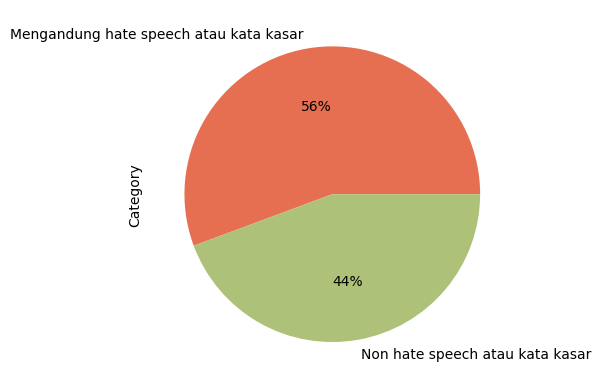

In [39]:
# Visualization

data_twitter['Category'].value_counts().plot.pie(autopct='%1.0f%%', colors = ['#e76f51','#adc178'])